In [ ]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
#training and testing sets of 28x28 handwritten digits 0-9, 60,000 for traing and 10, for testing
#each entry is vector of 784 integers, each from 0-255 representing intensity of the pixel
#MNIST: dataset of 70,000 images of
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training and testing sets of 28x28 handwritten digits 0-9, 60,000 for traing and 10, for testing
each entry is vector of 784 integers, each from 0-255 representing intensity of the pixel
MNIST: dataset of 70,000 images

In [ ]:
#we preprocess the images by modelling each pixel with a Bernoulli distribution, then we binarize the dataset
def preprocess_images(images):
  images = images.reshape((images.shape[0],28,28,1))/255.0
  return np.where(images>0.5,1.0,0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
train_size = 60000
batch_size = 32
test_size = 10000

#use tf.data to batch and shuffle data
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

We preprocess the images by modelling each pixel with a Bernoulli distribution, then we binarize the dataset



Now we must define the encoder and decoder networks

Encoder network defines the distribution of the p(z|x)
where x denotes the obsveration and z denotes the latent variable
the model will simply output the distributions as a guassian and outputs to log-variance and mean

Decoder network defines the distribution of p(x|z)
 takes a latent sample and outputs the parameters for a conditional distribution of the observation

 to generate a sample z for the decoder, we sample from the latent distrubtion defined from the encoder
z = m + o*e, where z is the sample, m is the mean, o is the standard deviation, and e can be thought of as random noise

for the encoder nework, we use two convolutional layers followed by a fully connected layer.

In [ ]:
#now we must define the encoder and decoder networks

#Encoder network defines the distribution of the probability of z given x
#where x denotes the obsveration and z denotes the latent variable
#the model will simply output the distributions as a guassian and outputs to log-variance and mean

#Decoder network defines the distribution of p(x|z)
# takes a latent sample and outputs the parameters for a conditional distribution of the observation

# to generate a sample z for the decoder, we sample from the latent distrubtion defined from the encoder
#z = m + o*e, where z is the sample, m is the mean, o is the standard deviation, and e can be thought of as random noise

#for the encoder nework, we use two convolutional layers followed by a fully connected layer.

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE,self).__init__()
    self.latent_dim = latent_dim
    # Renamed to avoid conflict with the `encode` method
    self.encoder_net = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=(2,2),activation='relu'),
        tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(2,2),activation='relu'),
        tf.keras.layers.Flatten(),
        #no activation
        tf.keras.layers.Dense(latent_dim+latent_dim)
    ])
    # Renamed to avoid conflict with the `decode` method
    self.decoder_net = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
        tf.keras.layers.Dense(units=7*7*32,activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(7,7,32)),
        tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',activation='relu'),
        #no activation
        tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=1,padding='same')
    ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100,self.latent_dim))
    return self.decode(eps,apply_sigmoid=True)

  def encode(self,X):
    # Call the encoder_net Sequential model
    mean, logvar = tf.split(self.encoder_net(X), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean

  def decode (self, z, apply_sigmoid=False):
    # Call the decoder_net Sequential model
    logits = self.decoder_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

To compute Loss, we maximize evidence lower bound (ELBO) on the marginal log likelihood. Log marginal likelihood can be derived the following way:
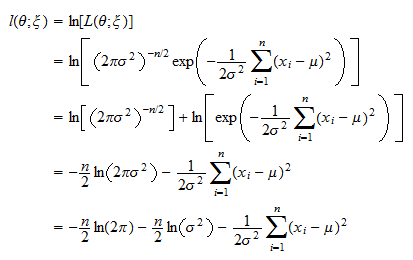

Where we assume the probability function follows a normal distribution. ELBO gives us a lower bound on the log-likelihood: Baye's Theorem says that p(x) = p(x|z)p(z)/q(z|x). By taking the log of that we get logp(x) >= logp(x|z) + logp(z) - logq(z|x)



In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

#log likelihood function --insert explanation of the function here, including its derivation
# using guassian distribution as pdf
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2.0 * np.pi)
  return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.math.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, X):
  mean, logvar = model.encode(X)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=X) # Changed 'x' to 'X'
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
  logpz = log_normal_pdf(z, 0.0, 0.0) # Changed 0 to 0.0
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, X, optimizer):
  """Computes loss and gradients, and uses the latter to update the parameters"""
  with tf.GradientTape() as tape:
    loss = compute_loss(model, X)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss # Return the loss from train_step


This model implements Adam optimization, which is a form of gradient descent that adapts its learning rate according to it the gradient, enabling faster convergence compared to a fixed learning rate.
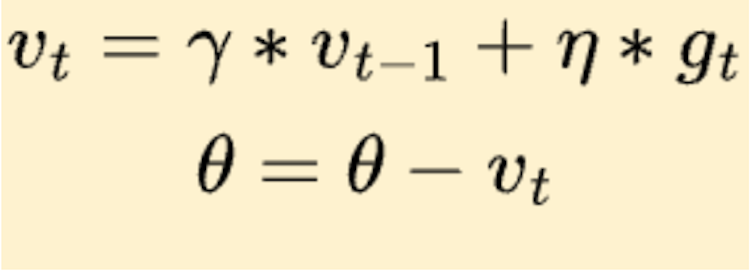



In [ ]:
#Training
#pass images to encoder to obtain means and logvars of q(z|x)
#apply reparameterization trick
#pass reparameterized samples to decoder to obtain logits p(x|z)

#Generating images
#sample a set of latent vectors from p(z)
#it will convert the latent sample z to logits, giving p(x|z)

epochs = 10
latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch: 10, Test set ELBO: -158.09182739257812, time elapse for current epoch: 77.17833256721497


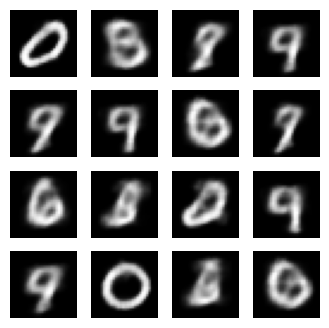

In [ ]:
latent_dim = 2 # Re-define latent_dim for self-contained execution
model = CVAE(latent_dim) # Re-instantiate the model with the updated CVAE class
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

generate_and_save_images(model, 0, test_sample)

train_losses = [] # List to store training losses per epoch
test_elbos = [] # List to store test ELBOs per epoch

for epoch in range(1, epochs + 1):
  start_time = time.time()
  epoch_train_loss_avg = tf.keras.metrics.Mean() # To average training loss over batches
  for train_x in train_dataset:
    batch_loss = train_step(model, train_x, optimizer) # Capture batch loss
    epoch_train_loss_avg(batch_loss)
  train_losses.append(epoch_train_loss_avg.result().numpy()) # Store average training loss
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  test_elbos.append(elbo.numpy()) # Store test ELBO
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)


(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

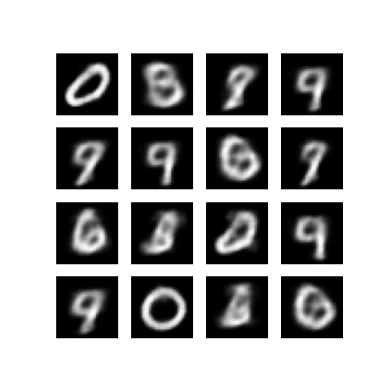

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, [-elbo_val for elbo_val in test_elbos], label='Test ELBO (negative)')
plt.xlabel('Epoch')
plt.ylabel('Loss / Negative ELBO')
plt.title('Training Loss and Test ELBO Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Summary of Work

This notebook demonstrates the implementation and training of a Convolutional Variational Autoencoder (CVAE) for generating handwritten digits from the MNIST dataset. The key steps performed include:

1.  **Data Loading and Preprocessing**: The MNIST dataset was loaded, and images were preprocessed by reshaping and binarizing them to be suitable for the Bernoulli distribution in the CVAE's decoder.
2.  **Dataset Preparation**: The preprocessed images were batched and shuffled using `tf.data.Dataset` for efficient training.
3.  **CVAE Model Definition**: A `CVAE` class was defined, incorporating an encoder (using convolutional layers to extract features and produce latent space parameters) and a decoder (using transposed convolutional layers to reconstruct images from latent samples).
4.  **Loss Function and Optimizer**: The evidence lower bound (ELBO) was implemented as the loss function, and the Adam optimizer was chosen for training.
5.  **Training Loop**: The model was trained over several epochs, with images generated and saved at each epoch to visualize the learning progress.
6.  **Latent Space Visualization**: A scatter plot was generated to visualize the 2D latent space learned by the encoder, showing how different test images are represented in this compressed space.

/tmp/ipython-input-4206607558.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(test_latent_means[:, 0], test_latent_means[:, 1], cmap='viridis', s=10)


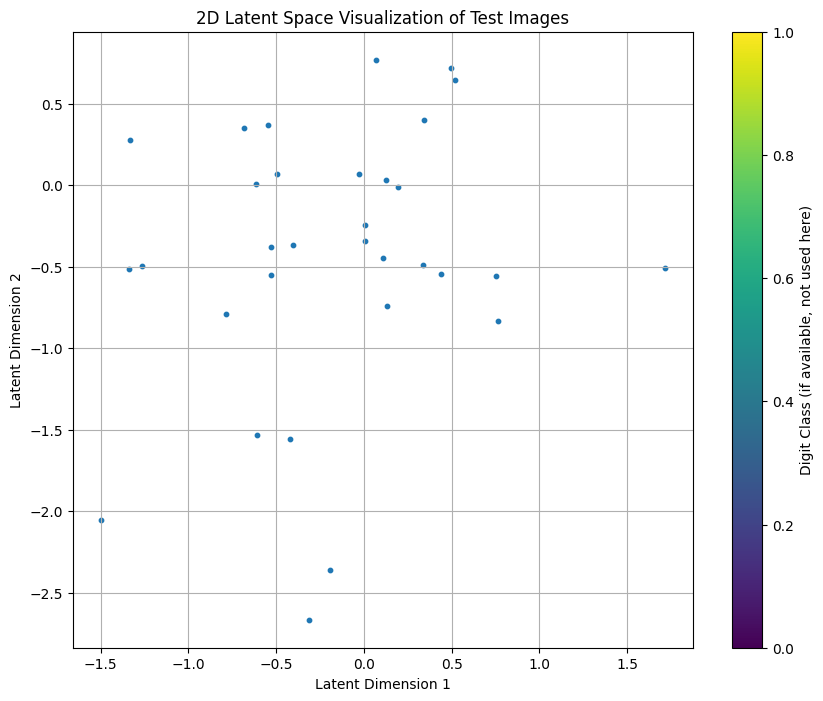

In [ ]:
import matplotlib.pyplot as plt

# Take a batch of test images
for test_x in test_dataset.take(1):
    test_latent_means, _ = model.encode(test_x)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
plt.scatter(test_latent_means[:, 0], test_latent_means[:, 1], cmap='viridis', s=10)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization of Test Images')
plt.colorbar(label='Digit Class (if available, not used here)')
plt.grid(True)
plt.show()
